In [246]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [247]:
# !pip uninstall urllib3
# !pip install --upgrade urllib3

In [248]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [250]:


df_train = pd.read_csv("/drive/My Drive/ML final project/train.csv", header=None,names=['ID', 'sentence', 'selected_sentence', 'sentiment'])
#, delimiter='\t', header=None, names=['textID', 'text', 'selected_text', 'sentiment']    delimiter='\t', header=None,
df_test = pd.read_csv("/drive/My Drive/ML final project/test.csv", header=None,names=['ID', 'sentence', 'sentiment'])


In [251]:
type(df_test)

pandas.core.frame.DataFrame

In [252]:
a = df_train.sentence
type(a)

pandas.core.series.Series

In [253]:
import re

def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text

In [254]:
a = '	#stackeoverflow http://bit.ly/13Nfk1'
print(preprocess(a))

stackeoverflow


In [255]:
df_train.head(20)

,ID,sentence,selected_sentence,sentiment
0,textID,text,selected_text,sentiment
1,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
2,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
3,088c60f138,my boss is bullying me...,bullying me,negative
4,9642c003ef,what interview! leave me alone,leave me alone,negative
5,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
6,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
7,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
8,50e14c0bb8,Soooo high,Soooo high,neutral
9,e050245fbd,Both of you,Both of you,neutral


In [256]:
type(df_train.selected_sentence.iloc[2])

str

In [257]:
# df_train['sentence'] = df_train.sentence.astype(str)
df_train["sentence"]=df_train.sentence.astype(str)
df_train.selected_sentence = df_train.selected_sentence.astype(str)

df_test.sentence = df_test.sentence.astype(str)

for index in range(df_train.shape[0]):
   string = df_train.selected_sentence.iloc[index]
   string = preprocess(string)
   string1 = df_train.sentence.iloc[index]
   string1 = preprocess(string1)
   # Select column by index position using iloc[]
   df_train.sentence.iloc[index] = string1
   df_train.selected_sentence.iloc[index]= string

for index in range(df_test.shape[0]):
   string = df_test.sentence.iloc[index]
   string = preprocess(string)
   df_test.sentence.iloc[index] = string

In [258]:
print('shape of train')
print(df_train.shape[0])
print('shape of test')
df_test.shape

shape of train
27482
shape of test


(3535, 3)

In [259]:
df_train

,ID,sentence,selected_sentence,sentiment
0,textID,text,selected text,sentiment
1,cb774db0d1,have responded if were going,have responded if were going,neutral
2,549e992a42,sooo sad will miss you here in san diego,sooo sad,negative
3,088c60f138,my boss is bullying me,bullying me,negative
4,9642c003ef,what interview leave me alone,leave me alone,negative
...,...,...,...,...
27477,4eac33d1c0,wish we could come see on denver husband lost ...,lost,negative
27478,4f4c4fc327,ve wondered about rake to the client has made ...,don force,negative
27479,f67aae2310,yay good for both of you enjoy the break you p...,yay good for both of you,positive
27480,ed167662a5,but it was worth it,but it was worth it,positive


In [260]:
# Iterate throught the dataset to replace semantic words to numeric number presentation 
for row, value in enumerate(df_train['sentiment']):
  if value == 'positive':
    df_train['sentiment'][row]= 2
  if value == 'neutral':
    df_train['sentiment'][row]= 1
  if value == 'negative':
    df_train['sentiment'][row]= 0

for row, value in enumerate(df_test['sentiment']):
  if value == 'positive':
    df_test['sentiment'][row]= 2
  if value == 'neutral':
    df_test['sentiment'][row]= 1
  if value == 'negative':
    df_test['sentiment'][row]= 0


In [261]:
df_test.head(30)

,ID,sentence,sentiment
0,textID,text,sentiment
1,f87dea47db,last session of the day,1
2,96d74cb729,shanghai is also really exciting precisely sky...,2
3,eee518ae67,recession hit veronique branquinho she has to ...,0
4,01082688c6,happy bday,2
5,33987a8ee5,like it,2
6,726e501993,that great weee visitors,2
7,261932614e,think everyone hates me on here lol,0
8,afa11da83f,soooooo wish could but im in school and myspac...,0
9,e64208b4ef,and within short time of the last clue all of ...,1


In [262]:
data=df_train[['sentence','sentiment']].copy()
data_test=df_test[['sentence','sentiment']].copy()
data_test

,sentence,sentiment
0,text,sentiment
1,last session of the day,1
2,shanghai is also really exciting precisely sky...,2
3,recession hit veronique branquinho she has to ...,0
4,happy bday,2
...,...,...
3530,its at am im very tired but can sleep but try it,0
3531,all alone in this old house again thanks for t...,2
3532,know what you mean my little dog is sinking in...,0
3533,sutra what is your next youtube video gonna be...,2


In [263]:
# data['selected_sentence'] = data['selected_sentence'].str.lower()
# data_test['sentence'] = data_test['sentence'].str.lower()

In [264]:
data.shape 

(27482, 2)

In [265]:
# stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
#              'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
#              'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
#              'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
#              'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
#              'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
#              'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
#              'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
#              'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
#              't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
#              'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
#              'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
#              'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
#              'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
#              "youve", 'your', 'yours', 'yourself', 'yourselves']

In [266]:
# STOPWORDS = set(stopwordlist)
# def cleaning_stopwords(text):
#     return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# data['selected_sentence'] = data['selected_sentence'].apply(lambda text: cleaning_stopwords(text))
# data_test['sentence'] = data_test['sentence'].apply(lambda text: cleaning_stopwords(text))

In [267]:
# import re
# def cleaning_numbers(data):
#     return re.sub('[0-9]+', '', data)


# def cleaning_repeating_char(text):
#     return re.sub(r'(.)1+', r'1', text)       #advanced substitude

# def cleaning_URLs(data):
#     return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

In [268]:
# import string

# english_punctuations = string.punctuation
# punctuations_list = english_punctuations
# def cleaning_punctuations(text):
#     translator = str.maketrans('', '', punctuations_list)
#     return text.translate(translator)

# data['selected_sentence']= data['selected_sentence'].apply(lambda x: cleaning_punctuations(x))
# data['selected_sentence'] = data['selected_sentence'].apply(lambda x: cleaning_repeating_char(x))
# data['selected_sentence'] = data['selected_sentence'].apply(lambda x: cleaning_numbers(x))
# data['selected_sentence'] = data['selected_sentence'].apply(lambda x: cleaning_URLs(x))

# data_test['sentence'] = data_test['sentence'].apply(lambda x: cleaning_punctuations(x))
# data_test['sentence'] = data_test['sentence'].apply(lambda x: cleaning_repeating_char(x))
# data_test['sentence'] = data_test['sentence'].apply(lambda x: cleaning_numbers(x))
# data_test['sentence'] = data_test['sentence'].apply(lambda x: cleaning_URLs(x))

In [269]:
data= data[:5000]

In [270]:
N_train = df_train.shape[0]
data = data.loc[1:N_train-1,:]
data_test = data_test.loc[1:3533,:]

In [271]:
type(data)
data.shape

(4999, 2)

In [272]:
data.head()

,sentence,sentiment
1,have responded if were going,1
2,sooo sad will miss you here in san diego,0
3,my boss is bullying me,0
4,what interview leave me alone,0
5,sons of why couldn they put them on the releas...,0


In [273]:
data.sentiment.value_counts()

1    2022
2    1592
0    1385
Name: sentiment, dtype: int64

In [274]:
# Create sentence and label lists
sentences = data.sentence.values

sentences = sentences[1:]
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = data.sentiment.values
# labels = [int(float(label)) for label in labels]
# labels2 = []
# for ele in labels: 
#   labels2.append(int(ele))

labels =  labels[1:]
labels = labels.astype(np.int_)

In [275]:
# Create sentence and label lists
sentences_test = data_test.sentence.values

sentences_test = sentences_test[1:]
# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_test = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences_test]
labels_test = data_test.sentiment.values
# labels = [int(float(label)) for label in labels]
# labels2 = []
# for ele in labels: 
#   labels2.append(int(ele))

labels_test =  labels_test[1:]
labels_test = labels_test.astype(np.int_)
labels_test = labels_test[:3532]

In [276]:
# data_test.sentiment.shape
labels_test.shape

(3532,)

In [277]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [278]:

#Import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[1])
tokenized_texts_test = [tokenizer.tokenize(sent) for sent in sentences_test]
print ("Tokenize the first sentence:")
print (tokenized_texts_test[1])



Tokenize the first sentence:
['[CLS]', 'my', 'boss', 'is', 'bullying', 'me', '[SEP]']
Tokenize the first sentence:
['[CLS]', 'recession', 'hit', 've', '##ron', '##ique', 'bran', '##quin', '##ho', 'she', 'has', 'to', 'quit', 'her', 'company', 'such', 'shame', '[SEP]']


In [279]:
for  i in range(10): 
  print (tokenized_texts_test[i])

['[CLS]', 'shanghai', 'is', 'also', 'really', 'exciting', 'precisely', 'skyscraper', '##s', 'gal', '##ore', 'good', 't', '##wee', '##ps', 'in', 'china', 'sh', 'b', '##j', '[SEP]']
['[CLS]', 'recession', 'hit', 've', '##ron', '##ique', 'bran', '##quin', '##ho', 'she', 'has', 'to', 'quit', 'her', 'company', 'such', 'shame', '[SEP]']
['[CLS]', 'happy', 'b', '##day', '[SEP]']
['[CLS]', 'like', 'it', '[SEP]']
['[CLS]', 'that', 'great', 'wee', '##e', 'visitors', '[SEP]']
['[CLS]', 'think', 'everyone', 'hates', 'me', 'on', 'here', 'lo', '##l', '[SEP]']
['[CLS]', 'soo', '##oo', '##oo', 'wish', 'could', 'but', 'im', 'in', 'school', 'and', 'myspace', 'is', 'completely', 'blocked', '[SEP]']
['[CLS]', 'and', 'within', 'short', 'time', 'of', 'the', 'last', 'clue', 'all', 'of', 'them', '[SEP]']
['[CLS]', 'what', 'did', 'you', 'get', 'my', 'day', 'is', 'alright', 'haven', 'done', 'anything', 'yet', 'leaving', 'soon', 'to', 'my', 'steps', '##ister', 'though', '[SEP]']
['[CLS]', 'my', 'bike', 'was', 'p

In [280]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128


In [281]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

In [282]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [283]:
input_ids

array([[  101, 17111,  2080, ...,     0,     0,     0],
       [  101,  2026,  5795, ...,     0,     0,     0],
       [  101,  2054,  4357, ...,     0,     0,     0],
       ...,
       [  101,  4283, 15263, ...,     0,     0,     0],
       [  101,  2085,  2008, ...,     0,     0,     0],
       [  101,  2053,  2180, ...,     0,     0,     0]])

In [284]:
input_ids_test

array([[  101,  8344,  2003, ...,     0,     0,     0],
       [  101, 19396,  2718, ...,     0,     0,     0],
       [  101,  3407,  1038, ...,     0,     0,     0],
       ...,
       [  101,  2035,  2894, ...,     0,     0,     0],
       [  101,  2113,  2054, ...,     0,     0,     0],
       [  101, 26567,  2054, ...,     0,     0,     0]])

In [285]:
# Create attention masks
attention_masks_train = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_train.append(seq_mask)


attention_masks_test = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

In [286]:
print(len(attention_masks_test))
input_ids_test.shape

3532


(3532, 128)

In [287]:


# Use train_test_split to split our data into train and validation sets for training

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
#                                                             random_state=2022, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
#                                              random_state=2022, test_size=0.1)



In [288]:
# Convert all of our data into torch tensors, the required datatype for our model
# train_labels = torch.from_numpy(train_labels)
# train_inputs = torch.tensor(train_inputs)
# validation_inputs = torch.tensor(validation_inputs)
# train_labels = torch.tensor(train_labels)
# validation_labels = torch.tensor(validation_labels)
# train_masks = torch.tensor(train_masks)
# validation_masks = torch.tensor(validation_masks)


train_labels = torch.from_numpy(labels)
train_inputs = torch.tensor(input_ids)
train_labels = torch.tensor(train_labels)

validation_labels = torch.from_numpy(labels_test)
validation_labels = torch.tensor(validation_labels)
validation_inputs = torch.tensor(input_ids_test)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [289]:
print(validation_inputs.shape, validation_masks.shape, validation_labels.shape)

torch.Size([3532, 128]) torch.Size([3532, 128]) torch.Size([3532])


In [290]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [291]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

In [292]:


param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]



In [293]:


# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,lr=8e-6,warmup=.1)



t_total value of -1 results in schedule not being applied


In [294]:


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat), pred_flat



In [295]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')
#accuracy score
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        num = len(y_preds[y_preds==label])/len(y_true)
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}')
        print(num,'\n')

In [296]:


t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    print('new loss: ',loss,'step: ',step)
    # ,'batch: ',batch
    train_loss_set.append(loss.item())
    # print('train_loss_set: ',train_loss_set)    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  pred_list = [] 
  true_v_list = []
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy,pred_flat = flat_accuracy(logits, label_ids)
    # pred_list = pred_list + pred_flat
    # true_v_list = true_v_list + label_ids
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  # val_f1 = f1_score_func(pred_list, true_vals)
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  
  # acc  = accuracy_per_class(predictions, true_vals)



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

new loss:  tensor(1.0873, grad_fn=<NllLossBackward0>) step:  0
new loss:  tensor(1.1056, grad_fn=<NllLossBackward0>) step:  1
new loss:  tensor(1.0271, grad_fn=<NllLossBackward0>) step:  2
new loss:  tensor(1.1750, grad_fn=<NllLossBackward0>) step:  3
new loss:  tensor(1.1305, grad_fn=<NllLossBackward0>) step:  4
new loss:  tensor(1.1087, grad_fn=<NllLossBackward0>) step:  5
new loss:  tensor(1.1149, grad_fn=<NllLossBackward0>) step:  6
new loss:  tensor(1.1595, grad_fn=<NllLossBackward0>) step:  7
new loss:  tensor(1.1363, grad_fn=<NllLossBackward0>) step:  8
new loss:  tensor(1.0557, grad_fn=<NllLossBackward0>) step:  9
new loss:  tensor(1.0559, grad_fn=<NllLossBackward0>) step:  10
new loss:  tensor(1.0846, grad_fn=<NllLossBackward0>) step:  11
new loss:  tensor(1.1216, grad_fn=<NllLossBackward0>) step:  12
new loss:  tensor(1.0680, grad_fn=<NllLossBackward0>) step:  13
new loss:  tensor(1.0356, grad_fn=<NllLossBackward0>) step:  14
new loss:  tensor(1.1026, grad_fn=<NllLossBackward

Epoch: 100%|██████████| 1/1 [37:36<00:00, 2256.28s/it]

Validation Accuracy: 0.7497184684684685


In [297]:
log1 = np.argmax(logits, axis=1).flatten()

In [298]:
model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
pred_list = [] 
true_v_list = []
# Evaluate data for one epoch
for batch in validation_dataloader:
# Add batch to GPU
# batch = tuple(t.to(device) for t in batch)
# Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
# Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
  # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

# Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  tmp_eval_accuracy,pred_flat = flat_accuracy(logits, label_ids)
  pred_list.extend(pred_flat)
  true_v_list.extend(label_ids)

  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1



In [299]:
print('pred',len(pred_list))
print('true',len(true_v_list))
print(pred_list[1])
print(true_v_list[1])

pred 3532
true 3532
0
0


In [300]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
def model_Evaluate(y_pred,y_test):   #三分类
  # Predict values for Test dataset
    # y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
    # y_test = np.argmax(y_test, axis = 1)
    # y_pred = np.argmax(y_pred, axis = 1)
    print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Netrual','Positive']
    group_names = ['True Negative','False Netrual','False Positive', 'False Negative','True Netrual','False Positive','False Negative','False Netrual','True Positive']
    group_percentages = ['\n{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}{v2}' for v1, v2 in zip(group_names, group_percentages)]
  
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1001
           1       0.70      0.74      0.72      1429
           2       0.83      0.76      0.79      1102

    accuracy                           0.75      3532
   macro avg       0.76      0.75      0.75      3532
weighted avg       0.75      0.75      0.75      3532



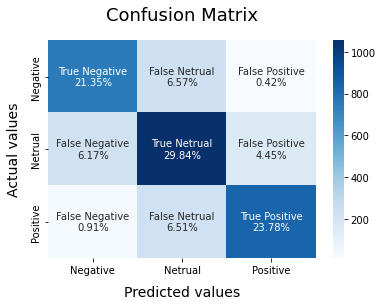

In [301]:
model_Evaluate(pred_list,true_v_list)

Text(0.5, 0, 'steps')

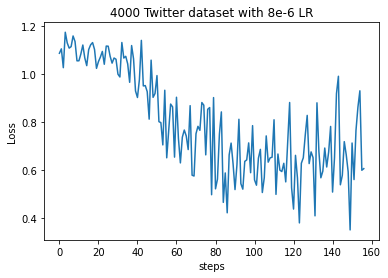

In [302]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss_set)
#this is not nessisary but makes your plot more readable
plt.title("5000 Twitter dataset with 8e-6 LR")
plt.ylabel('Loss')
plt.xlabel('steps')